In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


This notebook is a short demo to illustrate execution.   For odd historical reasons, it uses "toy Monte Carlo" (simulated data)for "training" and "full LHCB MC" for validation.

The network architecture is a "simple" model that uses 1 input channel (the KDE [kernel density estimator] but from the track parameters) feeding 5 convolutional layers followed by a fully connected layer.

In today's version, the network will start with weights from a previously trained version.
 

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Thu Jul  2 16:59:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 34%   40C    P8    24W / 250W |     12MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   32C    P0    27W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

from torchsummary import summary

### Set up local parameters

In [4]:
n_epochs = 20

# Name is the output file name


##  190810  mds
folder = '02July2020_From_SimpleCNN_toAllCNN_01'
name = '02July2020_From_SimpleCNN_toAllCNN_01'

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'ML/' + folder
output = Path(folder)


# Size of batches
batch_size = 128

# How fast to learn
learning_rate = 1e-3

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
# From model/collectdata.py
from model.collectdata_mdsA import collect_data

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below


##from model.models_mds_01June20 import SimpleCNN5Layer_Ca as Model
from model.models_mds_01June20 import All_CNN6Layer_A as Model

from model.training import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
device = select_gpu(0)

1 available GPUs (initially using device 0):
  0 TITAN V


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [9]:
## newer vernacular
## Training dataset. You can put as many files here as desired.

## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch
##  set the option load_XandXsq = True to use both DKE and KDE^2 as input features
train_loader = collect_data('dataAA/Aug14_80K_train.h5',
                            'dataAA/Oct03_80K_train.h5',
##                            'dataAA/Oct03_80K2_train.h5',
                             batch_size=batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
##                           device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=False,
                            load_xy=False)

# Validation dataset. You can slice to reduce the size.
## dataAA -> /share/lazy/sokoloff/ML-data_AA/
val_loader = collect_data('dataAA/Oct03_20K_val.h5',
## mds val_loader = collect_data('dataAA/HLT1CPU_1kevts_val.h5',

                          batch_size=batch_size,
                          slice=slice(256 * 39),
                          device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=False,
                          load_xy=False)

Loading data...
Loaded dataAA/Aug14_80K_train.h5 in 15.31 s
Loaded dataAA/Oct03_80K_train.h5 in 14.37 s
Constructing 160000 event dataset took 0.4087 s
Loading data...
Loaded dataAA/Oct03_20K_val.h5 in 3.525 s
Constructing 9984 event dataset took 2.751 s


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [17]:
model = Model()

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa
ct = 0
for child in model.children():
  print('ct, child = ',ct, "  ", child)
  if ct < 5:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

ct, child =  0    Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
     About to set param.requires_grad=False for ct =  0 params
ct, child =  1    Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
     About to set param.requires_grad=False for ct =  1 params
ct, child =  2    Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
     About to set param.requires_grad=False for ct =  2 params
ct, child =  3    Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
     About to set param.requires_grad=False for ct =  3 params
ct, child =  4    Conv1d(10, 1, kernel_size=(5,), stride=(1,), padding=(2,))
     About to set param.requires_grad=False for ct =  4 params
ct, child =  5    Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
ct, child =  6    Dropout(p=0.15, inplace=False)
ct, child =  7    Dropout(p=0.15, inplace=False)
ct, child =  8    Dropout(p=0.15, inplace=False)
ct, child =  9    Dropout(p=0.15, inplace=False)
ct, child =  10   

In [18]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


Let's move the model's weight matricies to the GPU:

In [19]:
print('output = ',output)

##  use the first five layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113

##   ML -> /share/lazy/sokoloff/ML
pretrained_dict = torch.load('ML/02June2020_CNN5Layer_Ca_yetAnother200epochs_K/02June2020_CNN5Layer_Ca_yetAnother200epochs_K_final.pyt')
model_dict = model.state_dict()
## mds 190725 for debugging
print("for model_dict")
index = 0
for k,v in model_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
    
print(" \n","  for pretrained_dict")
index = 0
for k,v in pretrained_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
## mds  

print("model_dict instantiated")
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}

print(" \n","  for 'reduced' pretrained_dict")
index = 0
for k,v in pretrained_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
## mds  
print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
print('model_dict updated')
##print('model_dict =    ', model_dict)
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

model.load_state_dict(model_dict,strict=False)

## print('model_dict =    ', model_dict)


output =  ML/02July2020_From_SimpleCNN_toAllCNN_01
for model_dict
index, k =   0    conv1.weight
index, k =   1    conv1.bias
index, k =   2    conv2.weight
index, k =   3    conv2.bias
index, k =   4    conv3.weight
index, k =   5    conv3.bias
index, k =   6    conv4.weight
index, k =   7    conv4.bias
index, k =   8    conv5.weight
index, k =   9    conv5.bias
index, k =   10    finalFilter.weight
index, k =   11    finalFilter.bias
 
   for pretrained_dict
index, k =   0    conv1.weight
index, k =   1    conv1.bias
index, k =   2    conv2.weight
index, k =   3    conv2.bias
index, k =   4    conv3.weight
index, k =   5    conv3.bias
index, k =   6    conv4.weight
index, k =   7    conv4.bias
index, k =   8    conv5.weight
index, k =   9    conv5.bias
index, k =   10    fc1.weight
index, k =   11    fc1.bias
model_dict instantiated
 
   for 'reduced' pretrained_dict
index, k =   0    conv1.weight
index, k =   1    conv1.bias
index, k =   2    conv2.weight
index, k =   3    conv2.bia

<All keys matched successfully>

In [20]:
model = model.to(device)

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


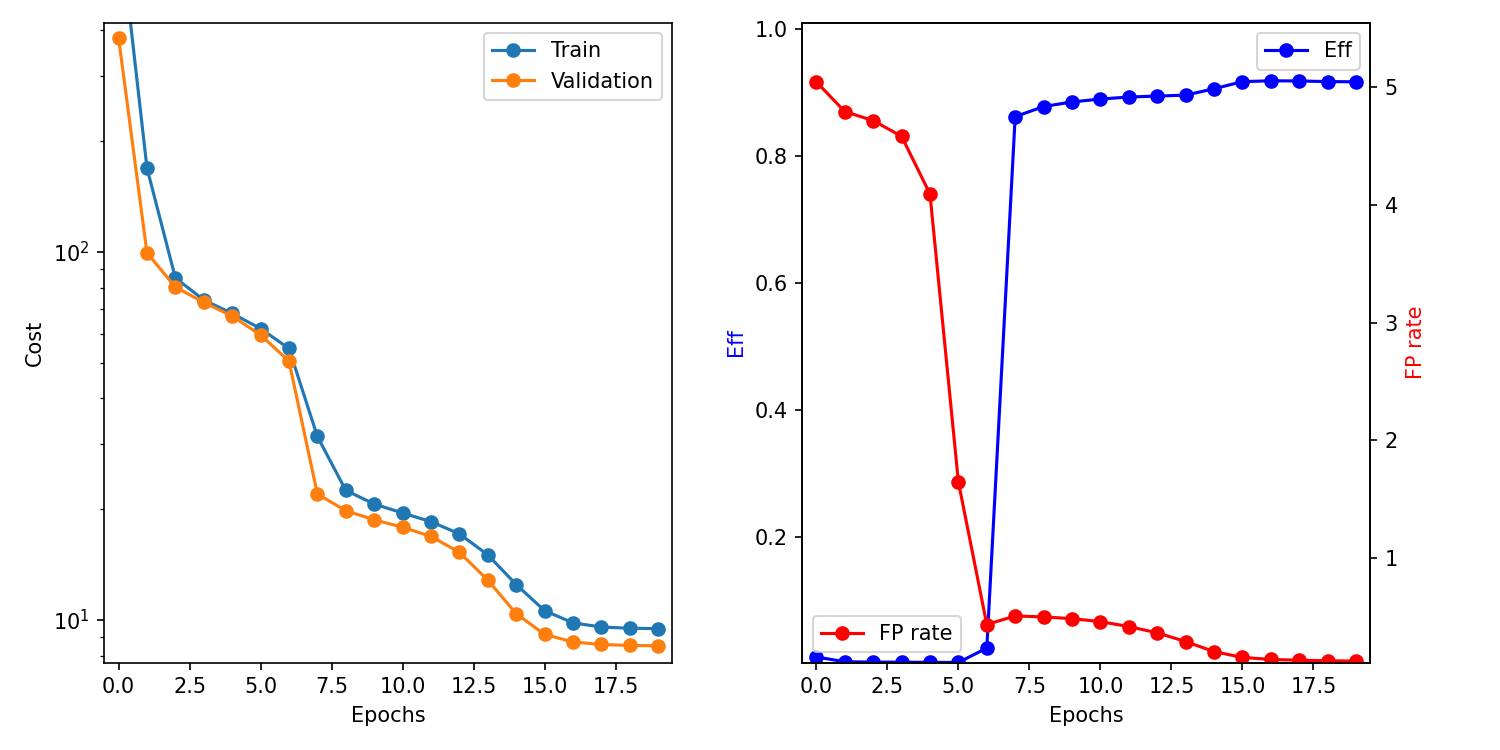

In [21]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [22]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)
    
    replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
    replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 1250, val = 78


Epoch 0: train=809.079, val=381.797, took 14.98 s
  Validation Found 580 of 54504, added 50392 (eff 1.06%) (5.05 FP/event)


Epoch 1: train=169.079, val=99.4157, took 14.778 s
  Validation Found 175 of 54504, added 47875 (eff 0.32%) (4.79 FP/event)


Epoch 2: train=84.9542, val=80.2593, took 13.93 s
  Validation Found 142 of 54504, added 47109 (eff 0.26%) (4.72 FP/event)


Epoch 3: train=74.0343, val=72.9, took 14.115 s
  Validation Found 137 of 54504, added 45773 (eff 0.25%) (4.58 FP/event)


Epoch 4: train=68.0369, val=66.8968, took 13.854 s
  Validation Found 117 of 54504, added 40878 (eff 0.21%) (4.09 FP/event)


Epoch 5: train=61.8687, val=59.4652, took 13.645 s
  Validation Found 112 of 54504, added 16458 (eff 0.21%) (1.65 FP/event)


Epoch 6: train=54.6367, val=50.4792, took 14.235 s
  Validation Found 1345 of 54504, added 4357 (eff 2.47%) (0.436 FP/event)


Epoch 7: train=31.5188, val=21.9851, took 13.981 s
  Validation Found 46968 of 54504, added 5086 (eff 86.17%) (0.509 FP/event)


Epoch 8: train=22.4847, val=19.807, took 14.267 s
  Validation Found 47836 of 54504, added 5002 (eff 87.77%) (0.501 FP/event)


Epoch 9: train=20.6474, val=18.7054, took 13.561 s
  Validation Found 48231 of 54504, added 4858 (eff 88.49%) (0.487 FP/event)


Epoch 10: train=19.5238, val=17.859, took 13.982 s
  Validation Found 48478 of 54504, added 4604 (eff 88.94%) (0.461 FP/event)


Epoch 11: train=18.4886, val=16.8571, took 14.536 s
  Validation Found 48653 of 54504, added 4185 (eff 89.27%) (0.419 FP/event)


Epoch 12: train=17.1327, val=15.2657, took 13.776 s
  Validation Found 48735 of 54504, added 3654 (eff 89.42%) (0.366 FP/event)


Epoch 13: train=15.025, val=12.8259, took 13.582 s
  Validation Found 48815 of 54504, added 2915 (eff 89.56%) (0.292 FP/event)


Epoch 14: train=12.4768, val=10.3964, took 13.673 s
  Validation Found 49360 of 54504, added 2059 (eff 90.56%) (0.206 FP/event)


Epoch 15: train=10.5946, val=9.13398, took 13.823 s
  Validation Found 49975 of 54504, added 1570 (eff 91.69%) (0.157 FP/event)


Epoch 16: train=9.81839, val=8.71081, took 14.114 s
  Validation Found 50046 of 54504, added 1393 (eff 91.82%) (0.14 FP/event)


Epoch 17: train=9.56418, val=8.57676, took 13.879 s
  Validation Found 50031 of 54504, added 1328 (eff 91.79%) (0.133 FP/event)


Epoch 18: train=9.49088, val=8.52121, took 13.572 s
  Validation Found 49978 of 54504, added 1283 (eff 91.70%) (0.128 FP/event)


Epoch 19: train=9.47112, val=8.50753, took 13.903 s
  Validation Found 49960 of 54504, added 1254 (eff 91.66%) (0.126 FP/event)



# Results

Let's save some results: (even though if you have not changed the code above, it saves the model every epoch)

Go ahead and save the final model (even though it was also saved above):

In [23]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

Save the output results:

In [24]:
results.to_hdf(f'{name}_stats.hdf5', 'results')

/data/conda/envs/goofit-june2020/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['epoch', 'eff_val'], dtype='object')]

  encoding=encoding,


Save the plot above:

<IPython.core.display.Javascript object>


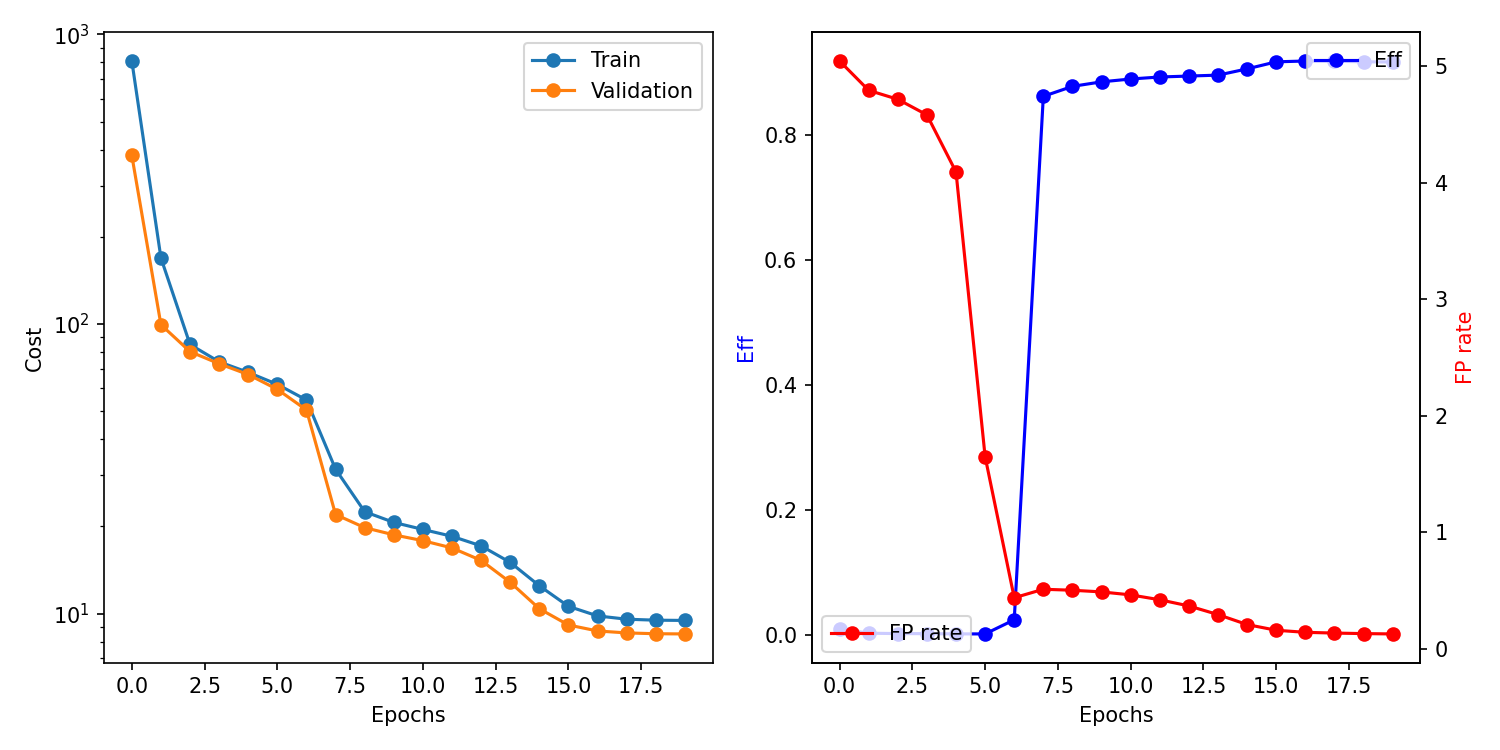

In [25]:
dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

In [ ]:
##quit()